## Reference: 
### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
### https://towardsdatascience.com/the-quora-question-pair-similarity-problem-3598477af172

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import gc
import xgboost as xgb
import time
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler

## Read dataset

In [2]:
df = pd.read_csv("Final_Training_V01.csv")
# Seed for reproducability
seed = 1234
np.random.seed(seed)
X_raw = df.copy()
X_raw.drop(columns=["is_duplicate"], inplace=True)
y_raw = df["is_duplicate"]

<AxesSubplot:>

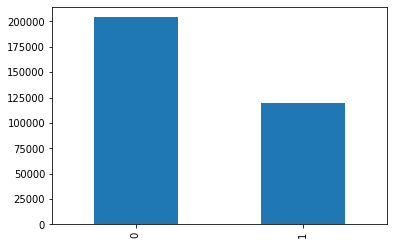

In [3]:
y_raw.value_counts().plot(kind='bar')

## Balance Dataset

In [4]:
over = RandomOverSampler(sampling_strategy="minority")
X, y = over.fit_resample(X_raw, y_raw)

<AxesSubplot:>

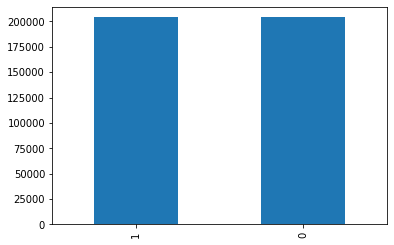

In [5]:
y.value_counts().plot(kind='bar')

## Normalize the dataset

In [6]:
#Normalize the dataset
from sklearn.preprocessing import StandardScaler
#Normalize the dataset
sc = StandardScaler()
X_normalized = sc.fit_transform(X)

## Split train and test data

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_normalized, 
                                                      y, 
                                                      test_size=0.20, 
                                                      random_state=seed)

In [8]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((326435, 626), (81609, 626), (326435,), (81609,))

In [9]:
gc.collect()

0

## Implement XGBoost Cross Validation

In [10]:
#Define XGBoost parameters
params = dict(
            objective = "binary:logistic",
            eval_metric = "logloss",
            #booster = "gbtree",
            #tree_method = "hist",
            #grow_policy = "lossguide",
            max_depth = 4,
            eta = 0.1
        )

In [12]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

In [12]:
dataset = [(dtrain, 'train'), (dvalid, 'valid')]

In [13]:
start_time = time.time()
xgb_model = xgb.train(params, dtrain, 600, dataset, early_stopping_rounds=20, verbose_eval=10)
print("XGBoost Cross Validation Total Time:", time.time() - start_time)

/Users/snehalkarad/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[0]	train-logloss:0.65469	valid-logloss:0.65438
[10]	train-logloss:0.47444	valid-logloss:0.47188
[20]	train-logloss:0.42026	valid-logloss:0.41684
[30]	train-logloss:0.39805	valid-logloss:0.39459
[40]	train-logloss:0.38554	valid-logloss:0.38222
[50]	train-logloss:0.37686	valid-logloss:0.37388
[60]	train-logloss:0.37004	valid-logloss:0.36749
[70]	train-logloss:0.36533	valid-logloss:0.36312
[80]	train-logloss:0.36069	valid-logloss:0.35902
[90]	train-logloss:0.35639	valid-logloss:0.35518
[100]	train-logloss:0.35292	valid-logloss:0.35221
[110]	train-logloss:0.35013	valid-logloss:0.34987
[120]	train-logloss:0.34721	valid-logloss:0.34733
[130]	train-logloss:0.34481	valid-logloss:0.34536
[140]	train-logloss:0.34231	valid-logloss:0.34332
[150]	train-logloss:0.34003	valid-logloss:0.34157
[160]	train-logloss:0.33782	valid-logloss:0.33975
[170]	train-logloss:0.33572	valid-logloss:0.33806
[180]	train-logloss:0.33362	valid-logloss:0.33643
[190]	train-logloss:0.33178	valid-logloss:0.33498
[200]	train

In [14]:
y_pred = xgb_model.predict(dvalid)

In [15]:
y_pred

array([0.41368106, 0.80220824, 0.12333518, ..., 0.97210175, 0.74521035,
       0.4525213 ], dtype=float32)

In [16]:
y_pred_binary = []
for i in y_pred:
    if i >= 0.5:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

In [17]:
accuracy_score(y_valid, y_pred_binary)

0.8571971228663505

In [18]:
log_loss(y_valid, y_pred)

0.30830253593412493

In [20]:
pickle.dump(xgb_model, open('xgboost_withoutSVD_withCV_withSmote.pkl', 'wb'))

In [21]:
#Clear the memory with Garbage Collect
gc.collect()

37

## Load pickle file

In [10]:
loaded_model = pickle.load(open("xgboost_withoutSVD_withCV_withSmote.pkl", 'rb'))

In [13]:
y_pred = loaded_model.predict(dvalid)

In [14]:
y_pred_binary = []
for i in y_pred:
    if i >= 0.5:
        y_pred_binary.append(1)
    else:
        y_pred_binary.append(0)

In [17]:
print("Confusion Matrix: \n",confusion_matrix(y_valid, y_pred_binary))
print("\nClassification Report: \n", classification_report(y_valid, y_pred_binary))
print("Accuracy Score: ", accuracy_score(y_valid, y_pred_binary))
print("\nLog Loss: ", log_loss(y_valid, y_pred_binary))
print("\nLog Loss: ", log_loss(y_valid, y_pred))
print("\nAUC: ", roc_auc_score(y_valid, y_pred_binary))

Confusion Matrix: 
 [[33631  7115]
 [ 4539 36324]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.83      0.85     40746
           1       0.84      0.89      0.86     40863

    accuracy                           0.86     81609
   macro avg       0.86      0.86      0.86     81609
weighted avg       0.86      0.86      0.86     81609

Accuracy Score:  0.8571971228663505

Log Loss:  4.9323063539806276

Log Loss:  0.30830253593412493

AUC:  0.8571515753983884


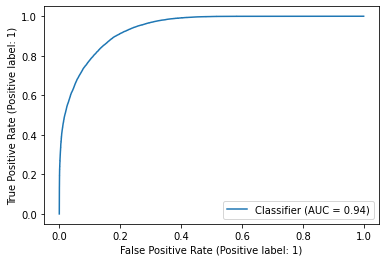

In [16]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
RocCurveDisplay.from_predictions(y_valid, y_pred)
plt.savefig('ROC', dpi=300)
plt.show()

## Load train data

In [7]:
df_test = pd.read_csv("Final_Test_V01.csv")
x_test = df_test.copy()
x_test.drop(columns=["is_duplicate"], inplace=True)
y_test = df_test["is_duplicate"]

In [13]:
#Normalize the dataset
sc = StandardScaler()
x_test_normalized = sc.fit_transform(x_test)

In [14]:
dtest = xgb.DMatrix(x_test_normalized, label=y_test)

In [16]:
y_test_pred = loaded_model.predict(dtest)

In [18]:
y_test_pred_binary = []
for i in y_test_pred:
    if i >= 0.5:
        y_test_pred_binary.append(1)
    else:
        y_test_pred_binary.append(0)

In [19]:
print("Confusion Matrix: \n",confusion_matrix(y_test, y_test_pred_binary))
print("\nClassification Report: \n", classification_report(y_test, y_test_pred_binary))
print("Accuracy Score: ", accuracy_score(y_test, y_test_pred_binary))
#print("\nLog Loss: ", log_loss(y_test, y_test_pred_binary))
print("\nLog Loss: ", log_loss(y_test, y_test_pred))
print("\nAUC: ", roc_auc_score(y_test, y_test_pred_binary))

Confusion Matrix: 
 [[40585 10420]
 [ 3417 26436]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.80      0.85     51005
           1       0.72      0.89      0.79     29853

    accuracy                           0.83     80858
   macro avg       0.82      0.84      0.82     80858
weighted avg       0.85      0.83      0.83     80858

Accuracy Score:  0.8288728388038289

Log Loss:  5.9106257980855545

Log Loss:  0.3457273727654479

AUC:  0.8406227225491962


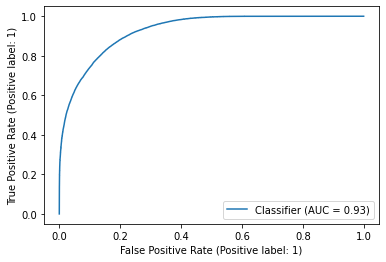

In [20]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
RocCurveDisplay.from_predictions(y_test, y_test_pred)
plt.savefig('ROC', dpi=300)
plt.show()